# TI3145TU Midterm Assignment 
## Football Players Wages

We hope you enjoy this assignment, good luck!

Student names: XXX

Student numbers: XXX

### Imports

In [2]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

### Load data

In [3]:
# These are your training samples along with their labels
data = pd.read_csv('football_wages.csv')
data.head()

# You need to extract the features and the regression target. The regression target is 'log_wages'.

,age,height_cm,weight_kg,nationality_name,overall,potential,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_reactions,movement_balance,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,log_wages
0,27.0,183.0,76.0,b'Korea Republic',57.0,58.0,54.0,30.0,55.0,53.0,...,60.0,67.0,63.0,58.0,9.0,13.0,8.0,11.0,10.0,3.000000
1,21.0,182.0,70.0,b'France',61.0,72.0,58.0,63.0,46.0,62.0,...,47.0,65.0,31.0,33.0,9.0,11.0,9.0,12.0,11.0,3.000000
2,35.0,182.0,75.0,b'Korea Republic',68.0,68.0,62.0,68.0,68.0,70.0,...,61.0,69.0,36.0,40.0,8.0,12.0,7.0,12.0,6.0,3.301030
3,29.0,169.0,70.0,b'Paraguay',67.0,67.0,62.0,55.0,50.0,71.0,...,59.0,84.0,40.0,55.0,6.0,10.0,11.0,15.0,9.0,2.698970
4,30.0,176.0,74.0,b'Austria',65.0,65.0,63.0,49.0,53.0,63.0,...,58.0,75.0,65.0,64.0,12.0,15.0,10.0,8.0,10.0,3.477121


### Partition the data
Seperate the data and the label. Remove the nationality column, although this affect wages the amount of nations are large. This results in large sparse matrices when using one-hot-encoding which affects KNN performance.

In [4]:
# Shuffle the dataset to make sure the distribution is random before dividing in training and testing data
df = data.sample(n=len(data), random_state=30)
# Delete the nationality column, although this affect wages the amount of nations is large, which results in when using
# one-hot-encoding nationality becoming very important to the classifier.
df = df.drop(columns=['nationality_name'])
labels = df.iloc[:,:-1].columns.tolist()
# extract training data and labels
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]
print(type(X))

<class 'pandas.core.frame.DataFrame'>


### Inspect the data
Create a histogram to inspect the distribution of the data.

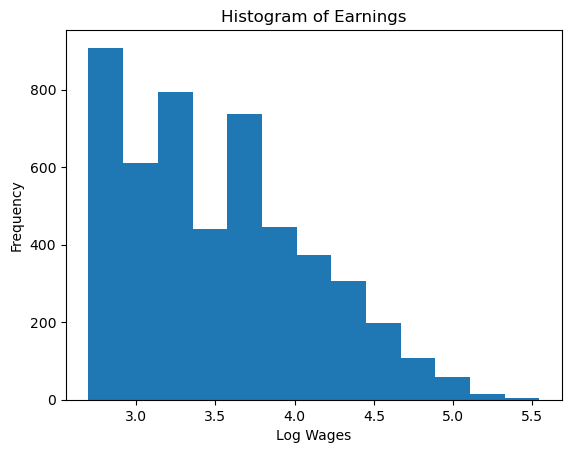

In [5]:
plt.figure()
plt.hist(Y.iloc[:], bins=13)
plt.title('Histogram of Earnings')
plt.xlabel('Log Wages')
plt.ylabel('Frequency')
plt.show()

### Scale the data
Scale each column to 0 mean and 1 variance; if not the KNN algorithm would be too heavily weighing data that have a larger absolute difference between them. Since the data is heavily left-skewed, outliers were chosen to not be removed.

In [6]:
# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(data=X, columns=labels)

### Pipeline 1
Create a random forest regressor to get an indication of what features are considered important for the tree classifier. And select the most important for testing of the kNN model.

In [7]:
# Create a random forrest classifier
nottingham_forest = RandomForestRegressor()
nottingham_forest.fit(X, Y)
importance = nottingham_forest.feature_importances_

# Create a dataframe to use when plotting result
importance_df = pd.DataFrame({'Labels': labels,
                   'Importance Coefficient': importance})
importance = importance_df.sort_values(by=['Importance Coefficient'], ascending=False)
print(importance)

                        Labels  Importance Coefficient
3                      overall                0.658952
0                          age                0.029473
4                    potential                0.016289
1                    height_cm                0.014909
18          movement_reactions                0.014435
7   attacking_heading_accuracy                0.014322
9            attacking_volleys                0.013986
20   defending_standing_tackle                0.013663
13          skill_long_passing                0.013628
12           skill_fk_accuracy                0.013585
8      attacking_short_passing                0.013180
6          attacking_finishing                0.013088
16       movement_sprint_speed                0.012835
11                 skill_curve                0.012696
21    defending_sliding_tackle                0.012099
14          skill_ball_control                0.012060
2                    weight_kg                0.011992
10        

Only choose features above a treshold, then multiply the features that we think is more important giving them a weighting. 

In [8]:
important_features = importance_df[importance_df['Importance Coefficient'] > 0.014]
pipe1 = X[important_features['Labels']].copy()
for col in pipe1.columns:
    important = important_features.loc[important_features['Labels'] == col, 'Importance Coefficient'].values[0]
    pipe1[col] = pipe1[col] * (1+important)
pipe1.std(axis=0)

age                           1.029576
height_cm                     1.015010
overall                       1.659118
potential                     1.016390
attacking_heading_accuracy    1.014424
movement_reactions            1.014536
dtype: float64

### Pipeline 2
Use SVD and PCA for feature reduction and select the 5 principel component.

In [9]:
U, S, Vt = np.linalg.svd(X, full_matrices=False)
Z = U @ np.diag(S)
nbr_PC = 3
pipe2 = Z[:,:nbr_PC]
pipe2 = pd.DataFrame(data=pipe2, columns=[f'PC{i+1}' for i in range(nbr_PC)])
pipe2

,PC1,PC2,PC3
0,0.904950,2.600444,-0.025998
1,1.816619,-0.019411,-0.692842
2,1.843094,-0.327307,0.028134
3,2.334801,0.238609,1.863567
4,-10.096754,-3.963023,3.382289
...,...,...,...
4995,3.329687,-0.542490,0.982918
4996,2.741437,0.594600,0.784019
4997,3.548376,-1.339937,0.439463
4998,1.897780,-0.210741,1.486546


### 

### Create training and validation dataset

In [10]:
training_size = 4000
pipe1_train = pipe1.iloc[:training_size,:]
pipe2_train = pipe2.iloc[:training_size,:]
pipe1_val = pipe1.iloc[training_size:,:]
pipe2_val = pipe2.iloc[training_size:,:]
y_train = Y.iloc[:training_size].values
y_val = Y.iloc[training_size:].values

### K-Nearest Neighbour

0.342849893832278


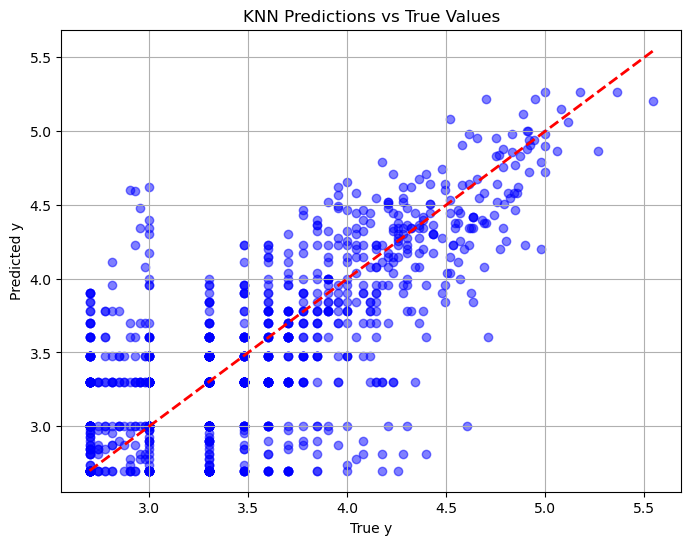

In [11]:
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(pipe1_train, y_train)
predictions = neigh.predict(pipe1_val)
AE = 0
for i in range(len(predictions)):
    AE += np.abs(y_val[i] - predictions[i])
MAE = AE / len(predictions)
print(MAE)

# Plot y_val vs predictions
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("KNN Predictions vs True Values")
plt.grid(True)
plt.show()


0.3915333488295811


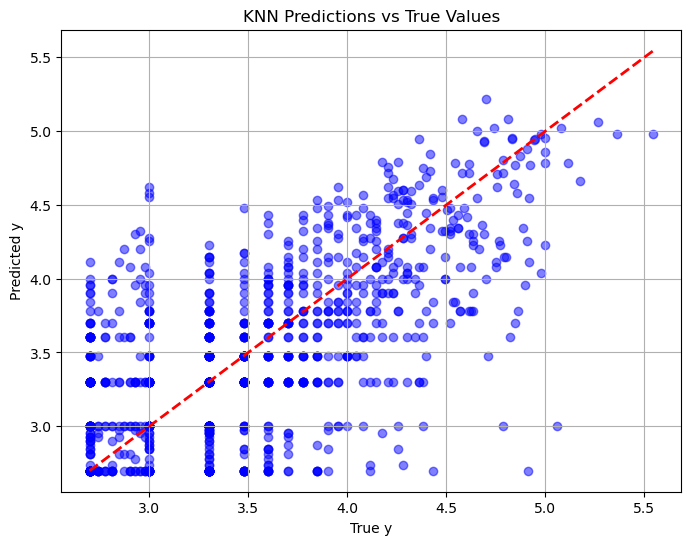

In [12]:
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(pipe2_train, y_train)
predictions = neigh.predict(pipe2_val)
AE = 0
for i in range(len(predictions)):
    AE += np.abs(y_val[i] - predictions[i])
MAE = AE / len(predictions)
print(MAE)

# Plot y_val vs predictions
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.ylabel("Predicted y")
plt.title("KNN Predictions vs True Values")
plt.grid(True)
plt.show()

### Linear Regressor with SGD


0.27932458305495866


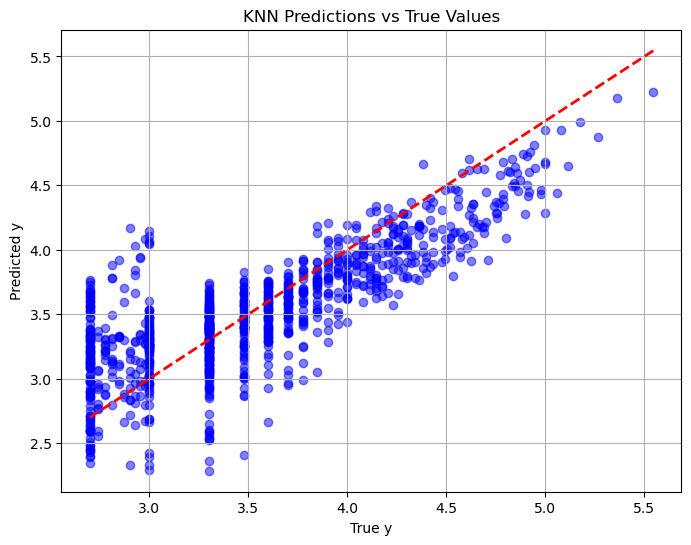

In [13]:
regressor = SGDRegressor(loss="squared_error")
regressor.fit(pipe1_train,y_train)
predictions = regressor.predict(pipe1_val)
AE = 0
for i in range(len(predictions)):
    AE += np.abs(y_val[i] - predictions[i])
MAE = AE / len(predictions)
print(MAE)

# Plot y_val vs predictions
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("KNN Predictions vs True Values")
plt.grid(True)
plt.show()

0.3073326697403513


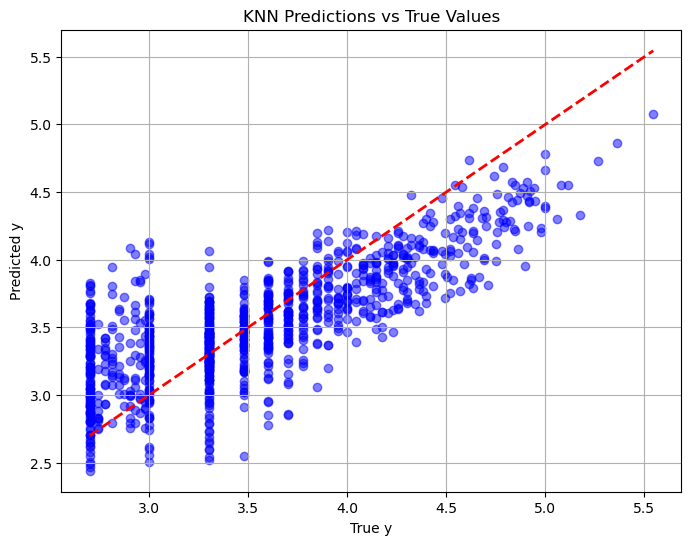

In [15]:
regressor = SGDRegressor(loss="squared_error")
regressor.fit(pipe2_train,y_train)
predictions = regressor.predict(pipe2_val)
AE = 0
for i in range(len(predictions)):
    AE += np.abs(y_val[i] - predictions[i])
MAE = AE / len(predictions)
print(MAE)

# Plot y_val vs predictions
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions, color='blue', alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("KNN Predictions vs True Values")
plt.grid(True)
plt.show()

### Autograder 

In the autograder you will need to provide two things: 1) estimate of the MAE of your model on unseen data, 2) the predictions on the autograder data. For the autograder data we only provide the features and not the regression targets. Thus, you cannot compute the MAE on this data yourself - you need to estimate that with the data provided above. 

In [16]:
data_autograder = pd.read_csv('football_autograde.csv')
data_autograder.head()


,age,height_cm,weight_kg,nationality_name,overall,potential,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_agility,movement_reactions,movement_balance,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,27.0,190.0,78.0,b'England',70.0,71.0,52.0,42.0,75.0,60.0,...,57.0,67.0,61.0,72.0,68.0,15.0,8.0,12.0,13.0,15.0
1,19.0,183.0,76.0,b'Republic of Ireland',59.0,77.0,45.0,20.0,53.0,60.0,...,66.0,55.0,69.0,59.0,57.0,8.0,11.0,10.0,6.0,11.0
2,20.0,172.0,67.0,b'China PR',48.0,53.0,40.0,34.0,38.0,52.0,...,57.0,56.0,70.0,35.0,43.0,12.0,6.0,9.0,7.0,12.0
3,28.0,170.0,65.0,b'Brazil',76.0,76.0,73.0,76.0,52.0,72.0,...,89.0,70.0,88.0,50.0,48.0,12.0,7.0,12.0,10.0,7.0
4,28.0,186.0,74.0,b'England',65.0,67.0,18.0,19.0,15.0,25.0,...,32.0,57.0,57.0,14.0,17.0,66.0,64.0,66.0,63.0,68.0


In [17]:
# TODO Replace this with your own estimate of the MAE of your best model
estimate_MAE_on_new_data = np.array([1.0])

# TODO Replace this with the predictions of your best model
# via e.g. prediction = model.predict(data_autograder)
# your predictions here should again be the $log_{10}(wage)$ of the football player, just as in the provided data. 
predictions_autograder_data = np.array([-1] * 14178)

# Upload this file to the Vocareum autograder:
result = np.append(estimate_MAE_on_new_data, predictions_autograder_data)
pd.DataFrame(result).to_csv("autograder_submission.txt", index=False, header=False)